### Deep Learning Supervised Text Classification
- BiLSTM

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [2]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [5]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json

### Load Data

In [6]:
# Load data from a minority category of interest
data_ref = '2209031206'
fn = f'data/prepared/{data_ref}_prepared_data.csv'
df = pd.read_csv(fn)
df

,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at twenty-two m depth se...,0
2,robodrill spider excavator being operated when...,1
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [7]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [8]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 107 [17, 82, 343, 355, 514, 534, 1559, 1750, 1960, 1965, 2117, 2142, 2380, 2447, 2482, 2701, 2867, 3526, 3619, 3672, 3759, 3803, 3880, 3908, 3989, 4047, 4118, 4355, 4374, 4421, 4890, 5244, 5444, 6371, 6584, 6585, 6831, 6935, 7814, 7969, 8551, 8704, 8794, 9041, 9153, 9201, 9381, 9556, 9596, 9659, 9815, 9826, 9829, 11286, 11403, 11658, 11684, 11779, 12091, 12196, 12517, 12669, 12830, 12882, 13467, 13652, 13715, 15027, 16050, 18773, 20094, 20272, 20446, 21302, 21344, 21919, 22531, 22578, 22835, 22993, 23279, 23358, 24007, 24075, 24310, 26148, 26401, 26864, 29258, 30436, 30716, 35411, 50966, 51336, 55157, 57713, 61714, 64840, 69153, 70741, 76577, 77778, 78574, 79345, 81714, 82479, 88394]
Train: 470 [2, 24, 46, 143, 151, 235, 237, 241, 273, 404, 443, 454, 490, 518, 548, 751, 813, 897, 994, 1024, 1188, 1296, 1373, 1399, 1401, 1418, 1461, 1513, 1531, 1537, 1546, 1556, 1558, 1587, 1678, 1684, 1704, 1754, 1774, 1812, 1857, 1883, 2041, 2043, 2066, 2075, 2120, 2123, 2124, 2131, 2199, 2215, 

In [10]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv('data/prepared/df_train_trues.csv')
df_train_trues

,text,category
2,robodrill spider excavator being operated when...,1
24,fuel red diesel spilled onto whiterockdirt sur...,1
46,oil leak from crane that was on site for plann...,1
143,small oil spill on twenty-one thousand and twe...,1
151,spider excavator hyd leak to soil 10ml spider ...,1
...,...,...
90259,struck by discharged object or substance an em...,1
90458,injured by slipping or swinging object held by...,1
90618,struck by swinging part of powered vehicle an ...,1
91361,caught in running equipment or machinery durin...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("/content/drive/MyDrive/Colab_Notebooks/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 68369
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3418500   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'a skid steer hydraulic hose broke causing no more than five gallons of hydraulic fluid to leak onto the ground at approximately one thousand, six hundred and fifteen on two million, one hundred and fifty-two thousand and twenty-two a logistics operator was transporting a skid steer to the entrance of block 3c for relocation a hydraulic hose on the boom of the skid steer broke causing less than five gallons of hydraulic fluid to leak onto the ground the leak was immediately noticed and the machine was stopped environmental swppp was notified and clean up procedures began the actual severity and potential ratings were selected as an a1 due to minimal reversible environmental impact the equipment was shut down environmental was notified clean up procedures immediately took place all contaminated soil and diapers were picked up and disposed of into proper containments'

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Train the model
history = model.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
587/587 [==============================] - 2069s 4s/step - loss: 0.0068 - categorical_accuracy: 0.9935 - val_loss: 0.0108 - val_categorical_accuracy: 0.9940
Epoch 2/4
587/587 [==============================] - 2069s 4s/step - loss: 0.0053 - categorical_accuracy: 0.9931 - val_loss: 0.0116 - val_categorical_accuracy: 1.0000
Epoch 3/4
587/587 [==============================] - 2060s 4s/step - loss: 0.0075 - categorical_accuracy: 0.9936 - val_loss: 0.0111 - val_categorical_accuracy: 0.9926
Epoch 4/4
587/587 [==============================] - 2048s 3s/step - loss: 0.0051 - categorical_accuracy: 0.9927 - val_loss: 0.0102 - val_categorical_accuracy: 0.9940


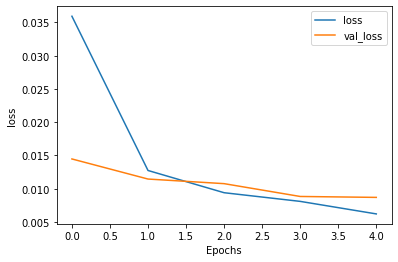

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.76      0.69      0.72       107

    accuracy                           1.00     18772
   macro avg       0.88      0.85      0.86     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Deepdive into the results / take a closer look...
tmp = pd.DataFrame(df['text'].iloc[len(X_train):], columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Dump results out for quick inspection in Excel (if required/desired)
tmp.to_csv('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/my_tmp_out.csv')

# Quick look at predicted positives
tmp[tmp['pred']==1]
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [ ]:
Counter(y_test)

Counter({0: 18665, 1: 107})

In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
75330,slip without fall nec an employee was stripping formwork from poured concrete using a prybar when the prybar slipped and caused him to lose balance the employee stepped back onto a piece of plywood which caused his foot to twist and fractured his right leg,1,0
75579,explosion of pressure vessel piping or tire a hose pressurized at nine thousand psi ruptured while being tested an employee left tibia was injured,1,0
76524,ignition of vapors gases or liquids an employee was circulating bad oil into tanks he then went to remove a leaking dump valve from a compressor to conduct repair while the dump valve was being removed fluids sprayed out and were ignited by the hot manifold of a compressor the employee sustained second degree burns to the palms and top surface of both hands and was hospitalized,1,0
76957,injured by slipping or swinging object held by injured worker an employee was removing an excavator bucket pin with a crowbar the crowbar slipped and struck the employee who fell and suffered a cut on the right side of his face a broken nose a possible broken right upper cheek sore neck muscles and a concussion the employee was hospitalized,1,0
77033,pedestrian struck by vehicle in nonroadway area unspecified on september twenty-five two thousand and nineteen a warehouse worker was picking up products on the floor when a forklift struck his right ankle while turning into a rack slot the employee right ankle was broken he was hospitalized,1,0
77114,caught in running equipment or machinery during regular operation an employee was bending a 2inch by 8inch piece of metal with a press brake the brake activated causing partial amputations to all four fingers on the employee right hand,1,0
77323,caught in running equipment or machinery during regular operation an employee was using a shear when his left middle finger was caught between the metal and the table being used to hold the metal resulting in a partial amputation,1,0
77383,struck against moving part of machinery or equipment an employee was cutting cardboard with a table saw the saw cut his left index finger,1,0
77427,other fall to lower level unspecified an employee fell while descending a step ladder and landed on a metal floor cart he was hospitalized with four broken ribs and a punctured lung,1,0
77638,nonclassifiable an employee had two fingers amputated during installation of a soilcave protection system,1,0



There are 86 entries (out of 107)...


In [ ]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')

,text,pred,rule_book
77914,contact with hot objects or substances two employees were removing a steel plug from a pump hot asphalt sprayed their faces causing burns,0,1
85416,other fall to lower level unspecified on august seventeen two thousand and twenty an employee was using a pry bar to remove nails from metal on the edge of a roof he fell off the roof to the concrete ground below suffering two broken wrists broken ribs a neck injury and a collapsed lung,0,1
85776,struck by object or equipment unspecified an excavator load struck an employee the employee was knocked over onto a steel diaphragm which caught the employee leg and pinned it as the employee continued to fall the leg was broken,0,1



There are 3 entries (out of 107, 2.8%)...


### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


In [ ]:
# Save the model
filename = f'/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/models/{time.strftime("%y%m%d%H%M")}_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [ ]:
imb_per = round(100*Counter(y_train)[1]/Counter(y_train)[0], 1)
print(f'{Counter(y_train)}, Percentage: {imb_per}%')

Counter({0: 74615, 1: 470}), Percentage: 0.6%


In [ ]:
print('Train: ', Counter(y_train))
print('Test: ', Counter(y_test))

Train:  Counter({0: 74615, 1: 470})
Test:  Counter({0: 18665, 1: 107})


In [ ]:
# Over and Under Sampling of Training Data
X = X_train_Glove
y = y_train

# Summarize again the class distribution
counter = Counter(y)
imb_per = round(100*Counter(y)[1]/Counter(y)[0], 1)
print(f'Base counts: {counter}, Percentage: {imb_per}%')

# Increase minority class to 10% of majority class (not undersampled)
over = SMOTE(sampling_strategy=0.1, random_state=193) #153

# Reduce majority class to 50% more than new minority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 

# Define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset using the pipeline
X, y = pipeline.fit_resample(X, y)

# Summarize the new class distribution
counter = Counter(y)
imb_per = round(100*Counter(y)[1]/Counter(y)[0], 1)
print(f'Mods counts: {counter}, Percentage: {imb_per}%')

Base counts: Counter({0: 74615, 1: 470}), Percentage: 0.6%
Mods counts: Counter({0: 14922, 1: 7461}), Percentage: 50.0%


In [ ]:
# Train the model
history = model.fit(X, y, validation_data=(X_test_Glove, y_test), epochs=5, batch_size=128, verbose=1)

Epoch 1/5
175/175 [==============================] - 664s 4s/step - loss: 0.2484 - accuracy: 0.8975 - val_loss: 0.0680 - val_accuracy: 0.9818
Epoch 2/5
175/175 [==============================] - 653s 4s/step - loss: 0.0897 - accuracy: 0.9719 - val_loss: 0.0373 - val_accuracy: 0.9861
Epoch 3/5
175/175 [==============================] - 660s 4s/step - loss: 0.0555 - accuracy: 0.9832 - val_loss: 0.0369 - val_accuracy: 0.9891
Epoch 4/5
175/175 [==============================] - 650s 4s/step - loss: 0.0401 - accuracy: 0.9878 - val_loss: 0.0326 - val_accuracy: 0.9923
Epoch 5/5
175/175 [==============================] - 650s 4s/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.0537 - val_accuracy: 0.9875


In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18665
           1       0.28      0.79      0.42       107

    accuracy                           0.99     18772
   macro avg       0.64      0.89      0.71     18772
weighted avg       0.99      0.99      0.99     18772



In [ ]:
# Deepdive into the results / take a closer look...
tmp = pd.DataFrame(df['text'].iloc[len(X_train):], columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test

# Dump results out for quick inspection in Excel (if required/desired)
tmp.to_csv('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/my_tmp_out.csv')

# Quick look at predicted positives
tmp[tmp['pred']==1]

18772


,text,pred,rule_book
75330,slip without fall nec an employee be strip for...,1,NaN
75350,catch in run equipment or machinery during mai...,1,NaN
75551,strike by fall object or equipment unspecified...,1,0.0
76181,other fall to lower level six to ten feet on e...,1,NaN
76218,pedestrian strike by vehicle in nonroadway are...,1,NaN
...,...,...,...
92712,catch in run equipment or machinery during reg...,1,NaN
92737,catch in or compress by equipment or object un...,1,NaN
93211,exposure to environmental heat an employee who...,1,0.0
93345,fall on same level unspecified an employee sli...,1,NaN


In [ ]:
X_test

62043    fire unspecified an employee be cut a cardboar...
45115    fall on same level due to trip over an object ...
3938     superficial cut to back of hand while walk pas...
15495    employees excavate for fire water line install...
92076    other fall to lower level six to ten feet an e...
                               ...                        
34306    catch in run equipment or machinery during reg...
83293    fall on same level due to trip over an object ...
50443    other fall to lower level unspecified an emplo...
9050     se use chainsaw to cut into twelve hdpe pipe r...
50769    other fall to lower level less than six feet w...
Name: text, Length: 18772, dtype: object

In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
75551,strike by fall object or equipment unspecified a large spool of electrical wire fell on an employee injure his hand,1,0.0
76587,vehicle or machinery fire an employee be service a compression unit when he begin to shut the unit down a flash fire occur he suffer primarily first and seconddegree burn he be hospitalize,1,0.0
81499,catch in run equipment or machinery during regular operation the operator of the upcut saw press the lever to lock down the guard and start the saw cycle as the guard be lower an employee who be responsible for takeoff reach to adjust the wood that be be cut the blade contact his right thumb amputate the tip,1,0.0
83028,strike by animal unspecified an employee be move a mule from one pasture to another when the animal spook and run her over break her leave femur,1,0.0
83237,other fall to lower level unspecified an employee be carry a ten to 12foot long metal channel up a metal ladder when he contact an overhead power line and receive an electrical shock he then fell from the ladder he sustain electrical burn and fracture,1,0.0
85530,part of occupantis body catch between vehicle and other object in nonroadway transport incident an employee be rid on the paver box when their finger be catch between the guardrail and the mechanical lift on the paver the employee leave middle and ring fingertips be amputate,1,0.0
85803,hit kick beat shove a customer punch an employee who hit his head on the grind because contusions and lose consciousness,1,0.0
86880,bite and sting unspecified an employee be provide pest service at a client home while the employee be in a shrub an insect bite him on the upper leave leg he be hospitalize,1,0.0
88863,fall on same level due to trip over an object on january nine two thousand and twentyone an employee be buff a floor with an orbital buffer the cord wrap around his ankle and he fell backward fracture his skull,1,0.0
89732,strike by fall object or equipment nec an employee be work at a bander station she be ask to help a forklift driver separate a unit of wooden mdf panel which have a bad panel on the 17th panel from the top the employee be stand on the leave side of the forklift give directions on fork position the forklift push sixteen panel from the stack which fell on top of the injure employee leg she be hospitalize with two break bone on her leave ankle and tear ligaments that require surgery,1,0.0



There are 15 entries (out of 107)...


### **ELMo Experiments**

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
elmo = hub.load("embeddings/elmo_3")

embeddings = elmo.signatures["default"](tf.constant([
                "i like green eggs and ham",
                "i like green ham and eggs"
                ])
                )["elmo"]
embeddings

<tf.Tensor: shape=(2, 6, 1024), dtype=float32, numpy=
array([[[-1.3958732 , -0.47634858, -0.42686176, ..., -0.44233394,
          0.36551443, -0.09755351],
        [-0.01843538, -0.48357862, -0.5191395 , ..., -0.75356627,
          0.18082404,  0.10429916],
        [-0.21239978, -0.54602855, -0.16077633, ...,  0.17620912,
          0.01360162,  0.41795295],
        [-0.07890837,  0.03399502,  0.29570353, ...,  0.14347483,
         -0.22136174,  0.3782219 ],
        [ 0.26714355,  0.04983564,  0.07959422, ..., -0.30136627,
         -0.03871743,  0.7418536 ],
        [-0.2634979 , -0.55771923,  0.44527853, ...,  0.31585732,
          0.0655691 ,  0.27271768]],

       [[-1.3958732 , -0.47634858, -0.42686176, ..., -0.44889042,
          0.45312953, -0.19382523],
        [-0.01843538, -0.48357862, -0.5191395 , ..., -0.76729155,
          0.19235286,  0.12666148],
        [-0.21239978, -0.54602855, -0.16077633, ...,  0.30678248,
          0.1808189 ,  0.26859784],
        [-0.17135648, -0.3

In [ ]:
# Output: TensorShape([Dimension(1), Dimension(8), Dimension(1024)])
# The output is a 3 dimensional tensor of shape (1, 8, 1024):
# - The first dimension of this tensor represents the number of test samples. This is 2 in our case
# - The second dimension represents the maximum length of the longest string in the input list of strings. Since we have only 1 string in our input list, the size of the 2nd dimension is equal to the length of the string – 6
# - The third dimension is equal to the length of the ELMo vector
# Hence, every word in the input sentence has an ELMo vector of size 1024.
embeddings.shape

TensorShape([2, 6, 1024])

In [ ]:
def elmo_vectors(x):
  embeddings = elmo.signatures["default"](tf.constant(x))["elmo"]
  # return average of ELMo features
  return tf.reduce_mean(embeddings, 1)

elmo_vectors(["Hello world", "My dog is funny"])

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.21239464, -0.51754075, -0.11204739, ..., -0.05436039,
         0.23724107,  0.14807077],
       [-0.03437573, -0.61900634, -0.11841337, ..., -0.05787318,
         0.26641753,  0.37589145]], dtype=float32)>

In [ ]:
train = df.sample(1000)
test = df.sample(1000)

In [ ]:
list_train = [train[i:i+100] for i in range(0, train.shape[0], 100)]
list_test = [test[i:i+100] for i in range(0, test.shape[0], 100)]

In [ ]:
for x in list_train:
    print(x['text'])

10834    a multifunction photocopy machine touch screen...
4105     whilst lab technician was placing sleeve back ...
10454    client ip felt unwell tibisay torrealba client...
30986    nonroadway noncollision incident nec an employ...
15255    employee was carrying a panel when he stepped ...
                               ...                        
81554    nonroadway collision with other vehicle unspec...
68218    fall on same level due to tripping over an obj...
36365    struck by falling object or equipment nec an e...
52454    pedestrian struck by forwardmoving vehicle in ...
72210    caught in running equipment or machinery durin...
Name: text, Length: 100, dtype: object
47120    struck against moving part of machinery or equ...
47354    fall on same level due to slipping an employee...
49662    fall on same level unspecified an employee was...
1438     bed of haul truck and rear of excavator made c...
66174    exposure to environmental heat an employee was...
                 